<a href="https://colab.research.google.com/github/Sinha123456/udacity_lesson_project/blob/main/A_BTesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# **Analyze A/B Test Results**


## **Introduction**

A/B tests are very commonly performed by data analysts and data scientists. It is important that you get some practice working with the difficulties of these

For this project, you will be working to understand the results of an A/B test run by an e-commerce website. The company has developed a new web page in order to try and increase the number of users who "convert," meaning the number of users who decide to pay for the company's product. Our goal is to work through this notebook to help the company understand if they should implement this new page, keep the old page, or perhaps run the experiment longer to make their decision.

In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

In [ ]:
#Loading the data and printing the few lines of first data
df1 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/udacity_projects/ab_data.csv')
df1.head(5)
         

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


## Exploring the data

In [ ]:
df1.isnull().sum() # There is no null values

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [ ]:
df1.duplicated().sum() #There is no duplicate values

0

In [ ]:
df1.nunique() #The number of unique users in the dataset.

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

In [ ]:
df1.shape 
#294478 rows and 5 columns

(294478, 5)

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [ ]:
df1.describe()

,user_id,converted
count,294478.000000,294478.000000
mean,787974.124733,0.119659
std,91210.823776,0.324563
min,630000.000000,0.000000
25%,709032.250000,0.000000
50%,787933.500000,0.000000
75%,866911.750000,0.000000
max,945999.000000,1.000000


In [ ]:
df1['user_id'].duplicated().sum()

3894

Do any of the rows have missing values?

No

## **Part I - Probability**

### The proportion of users converted.

In [ ]:
prop_convert_users = df1.query('converted == 1').count()[0]/df1.converted.shape[0]
prop_convert_users #12% of users converted

0.11965919355605512

The number of times the new_page and treatment don't match.

In [ ]:
df1[((df1['group'] == 'treatment') == (df1['landing_page'] == 'new_page')) == False].shape[0]

3893

In [ ]:
remove = list(df1[((df1['group']=='treatment') == (df1['landing_page']=='new_page'))==False].index)
df2 = df1.drop(remove)

 How many unique user_ids are in df2?

In [ ]:
df2.user_id.nunique()

290584

There is one user_id repeated in df2. What is it?

It's 773192

What is the row information for the repeat user_id? 

In [ ]:
df2[df2.duplicated('user_id')]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Remove one of the rows with a duplicate user_id, but keep your dataframe as df2.

In [ ]:
remove = df2.query('user_id==773192').index.values
df2 = df2.drop(remove)

In [ ]:
#check the duplicate of user_id is dropped or not.
df2[df2.duplicated('user_id')]

,user_id,timestamp,group,landing_page,converted


What is the probability of an individual converting regardless of the page they receive?


In [ ]:
new_convert = df2.query('landing_page=="new_page" and converted == 1').count()[0]/df2['converted'].count()
old_convert = df2.query('landing_page=="old_page" and converted == 1').count()[0]/df2['converted'].count()
individually_convert = new_convert+old_convert
individually_convert


0.11959749882133504

Given that an individual was in the control group, what is the probability they converted?

In [ ]:
df2.query('group=="control" and converted == 1').count()[0]/df2.query('group=="control"').count()[0]


0.1203863045004612

Given that an individual was in the treatment group, what is the probability they converted?

In [ ]:
df2.query('group=="treatment" and converted == 1').count()[0]/df2.query('group=="treatment"').count()[0]


0.11880888313869065

What is the probability that an individual received the new page?

In [ ]:
control = df2.query('group=="control" and landing_page == "new_page"').count()[0]/df2['landing_page'].count()
treatment = df2.query('group=="treatment" and landing_page == "new_page"').count()[0]/df2['landing_page'].count()
individual_new_page = control+treatment
individual_new_page

0.5000602237570677

Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

The probability of converting in control group is 0.1% higher than treatment group, we have evidence that there is a little increment of conversion, we might do little better to increase more conversion. Little change make a big effect sometimes. There is 12% pf users who converted treament they like new_page more than old_page. Probability of receiving new_page is 50%. We have all of these evidence that shows our new_page can have more conversions.

# Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time? How long do you run to render a decision that neither page is better than another?

These questions are the difficult parts associated with A/B tests in general.

1. For now, consider you need to make the decision just based on all the data provided. If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be? You can state your hypothesis in terms of words or in terms of 𝑝𝑜𝑙𝑑
and 𝑝𝑛𝑒𝑤, which are the converted rates for the old and new pages.

H0: Pnew <= Pold

H1 : Pnew > Pold

From the above calculations shows that there is a small increment in new page. In type 1 error, we reject null hypothesis in favour of alternative. We want to prove that new page is better than old page in favour of 5% of type 1 error rate.

2. Assume under the null hypothesis, 𝑝𝑛𝑒𝑤 and 𝑝𝑜𝑙𝑑 both have "true" success rates equal to the converted success rate regardless of page - that is 𝑝𝑛𝑒𝑤 and 𝑝𝑜𝑙𝑑

are equal. Furthermore, assume they are equal to the converted rate in ab_data.csv regardless of the page.

Use a sample size for each page equal to the ones in ab_data.csv.

Perform the sampling distribution for the difference in converted between the two pages over 10,000 iterations of calculating an estimate from the null. 

a. What is the conversion rate for 𝑝𝑛𝑒𝑤 under the null? 

b. What is the conversion rate for 𝑝𝑜𝑙𝑑 under the null? 

In [ ]:
p_new = p_old = df1['converted'].mean()
p_new, p_old

(0.11965919355605512, 0.11965919355605512)

c. What is 𝑛𝑛𝑒𝑤, the number of individuals in the treatment group?

In [ ]:
nnew = df2.query('group == "treatment"')['user_id'].shape[0]
nnew

145309

 What is 𝑛𝑜𝑙𝑑, the number of individuals in the control group?

In [ ]:
nold = df2.query('group == "control"')['user_id'].shape[0]
nold

145274

p_new - p_old under the null.

In [ ]:
p_new-p_old

0.0

e. Simulate 𝑛𝑛𝑒𝑤 transactions with a conversion rate of 𝑝𝑛𝑒𝑤 under the null. Store these 𝑛𝑛𝑒𝑤 1's and 0's in new_page_converted.

In [ ]:
#We need to check whether the simulated data creates a normal distribution or not. 
#In addition, we want to check what the data should look like under the null hypothesis.
new_page_converted = np.random.choice([0,1], size=nnew, p = [1-p_new, p_new])
new_page_converted

array([0, 0, 0, ..., 0, 0, 1])

f. Simulate 𝑛𝑜𝑙𝑑 transactions with a conversion rate of 𝑝𝑜𝑙𝑑 under the null. Store these 𝑛𝑜𝑙𝑑 1's and 0's in old_page_converted.

In [ ]:
old_page_converted = np.random.choice([0,1], size= nold, p=[1-p_old, p_old])
old_page_converted

array([0, 0, 1, ..., 0, 0, 0])

g. Find 𝑝𝑛𝑒𝑤 - 𝑝𝑜𝑙𝑑 for your simulated values from part (e) and (f).

In [ ]:
obs_diff = new_page_converted.mean() - old_page_converted.mean()
obs_diff

-0.002974901869082308

h. Create 10,000 𝑝𝑛𝑒𝑤 - 𝑝𝑜𝑙𝑑

values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called p_diffs.

​

In [ ]:
p_diffs = []
for _ in range(10000):
  new_converted = np.random.choice([0,1], size = nnew, p = [1-p_new, p_new])
  old_converted = np.random.choice([0,1], size= nold, p = [1-p_old, p_old])
  diff = new_converted.mean() - old_converted.mean()
  p_diffs.append(diff)
p_diffs = np.array(p_diffs)
(p_diffs>obs_diff).mean()

0.9937

i. Plot a histogram of the p_diffs. Does this plot look like what you expected? Use the matching problem in the classroom to assure you fully understand what was computed here.

​

Text(0, 0.5, 'count')

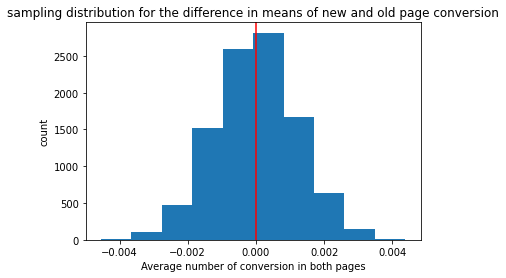

In [ ]:
plt.hist(p_diffs)
plt.title('sampling distribution for the difference in means of new and old page conversion')
plt.axvline(x = p_diffs.mean(), color = 'r')
plt.xlabel('Average number of conversion in both pages')
plt.ylabel('count')

Histogram of sampling distrbution seems to me normally distributed and our p value is to be right of the plot, pvalue is less than 5% so we reject null hypothesis in favor of alternative hypothesis.

j. What proportion of the p_diffs are greater than the actual difference observed in ab_data.csv?

​

In [ ]:
p_diffs = np.array(p_diffs) #converting p_diffs in array
p_diffs

array([-1.35011021e-03,  5.21845735e-04,  2.59961008e-04, ...,
        1.23424299e-05,  3.36097813e-04,  4.52799726e-04])

In [ ]:
#finding obseerved difference between tretment and control group conversion
observed_diff = df2.query('group == "treatment"')['converted'].mean()- df2.query('group == "control"')['converted'].mean()
observed_diff

-0.0015774213617705535

In [ ]:
#See the sampling distribution of group conversion is greater than the actual observation.
(p_diffs>observed_diff)

array([ True,  True,  True, ...,  True,  True,  True])

In [ ]:
#proportion of the p_diffs are greater than the actual difference observed in ab_data.csv
(p_diffs>observed_diff).mean()

0.9045

k. Please explain using the vocabulary you've learned in this course what you just computed in part j. What is this value called in scientific studies? What does this value mean in terms of whether or not there is a difference between the new and old pages?

Firstly, we setup our null and alternative hypothesis

H0: Pnew <= Pold

H1 : Pnew > Pold
In the first part we found the pvalue under the null hypothesis where all conversion of users were equal in treatment and control group. pvalue from the smapling distribution was 0.4121 means our p value is greater than 95% of confidence interval, Therefore, we do not have evidence that we can reject null hypothesis in favour of alternate. 
Pvalue is the probability of observing your static if the null hypothesis is true.

l. We could also use a built-in to achieve similar results. Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let n_old and n_new refer the the number of rows associated with the old page and new pages, respectively.

In [ ]:
import statsmodels.api as sm

convert_old = df2.query('landing_page== "old_page" and converted == 1').count()[0]
convert_new = df2.query('landing_page== "new_page" and converted == 1').count()[0]
n_old = df2.query('landing_page== "old_page"').count()[0]
n_new = df2.query('landing_page== "new_page"').count()[0]
print("converted_old:", convert_old)
print("converted_new:", convert_new)
print("n_old:", n_old)
print("n_new:", n_new)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


converted_old: 17489
converted_new: 17264
n_old: 145274
n_new: 145309


m. Now use stats.proportions_ztest to compute your test statistic and p-value. 

In [ ]:
#H0: pold = pnew
#H1: pold != pnew
#from statsmodels.stats.proportion import stats.proportions_ztest
no_of_success = ([17489,17264])
total_sample = ([145274, 145309])
z_score, p_value = sm.stats.proportions_ztest(no_of_success, total_sample, alternative='smaller')
print('z_score {}'.format(z_score))
print('p_value {}'.format(p_value))

z_score 1.3102408579271012
p_value 0.9049428161159749


In [ ]:
#critcal_value = (1-0.05)= 0.95
#from the z table of right tail 
1.65

1.65

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages? Do they agree with the findings in parts j. and k.?

In the previous question  pvlaue is exactly the as same as computed through statsmodel left tail test. In the begining question we set up that old page is better than new page in the null hypothesis in favour of 5% of type 1 error rate. From the all calculations with population and  with sample we found that pvalue is greater than 5% of type 1 error error rate. P vlaue is 0.9 which is grater than 0.05, It's not statistical significant and strong evidence for null hypothesis. We fail to reject null hypothesis.


## Part III - A regression approach

1.In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Logistic regression should be better for that dataset. Logistic regression is a regression approach used to predict only two possible outcomes, here we have to predict whether user convert to treatmetn group or not.

b. The goal is to use statsmodels to fit the regression model you specified in part a. to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received. Add an intercept column, as well as an ab_page column, which is 1 when an individual receives the treatment and 0 if control.

In [ ]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']


In [ ]:
df2.head(2)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0


c. Use statsmodels to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part b. to predict whether or not an individual converts. 

In [ ]:
logit = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366119
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290583
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            1
Date:                Fri, 05 Feb 2021   Pseudo R-squ.:               8.068e-06
Time:                        01:45:24   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1901
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.310      0.190      -0.037       0.007
==============================================================================
"""

In [ ]:
#log odds
print(results.params)

intercept   -1.988777
ab_page     -0.014981
dtype: float64


In [ ]:
np.exp(results.params)

intercept    0.136863
ab_page      0.985130
dtype: float64

In [ ]:
1/_

intercept    7.306593
ab_page      1.015094
dtype: float64

d. Provide the summary of your model below, and use it as necessary to answer the following questions.
p-value of ab_page is greater than the type 1 error rate that means our model is not statistically significant. When there is a unit change in the independent variable the corresponding change is the estimate of particular independent variable. Increasing of one unit conversion in ab_page (1-0.985 = .015*100) it's less likely by conversion of 1.5%

exp(−1.98877)=.14 or (1−.14)×100%= -86.6% of less likely ap_page.

when user is subjected to the group. So the odds of choosing treatment for those who were in control group and did not prefer treatment group by .14∗1.5= 0.21, so there 0.21% such user who prefer treatment for every such user who prefers control group. critical values = SE/coef
for baseline variable T = 0.008/-1.9888= -0.004, statistically significant
for ab_page = -0.0150/0.011 = - 1.36, not statistically significant.

e. What is the p-value associated with ab_page? Why does it differ from the value you found in Part II?

The p-value is 0.190 associated with ap_page which is higher than error rate.
The p-value is part II is 0.90 from z-test and and from the observed difference of conversion rate. In z-test we used one tail test, and the value was 0.90 which is higher than error rate. In the part II null and alternative hypothesis are:

H0: Pnew <= Pold

H1 : Pnew > Pold

In the regression model we are used two tail test:

H0: Pnew = Pold

H1 : Pnew != Pold

It is not statistically significant that new page is better than old page from the regression model.



f. Now, you are considering other things that might influence whether or not an individual converts. Discuss why it is a good idea to consider other factors to add into your regression model. Are there any disadvantages to adding additional terms into your regression model?

If we use other factors that might influence conversion rate in our webpage, but our model is not statistically significant in favour of alternative hypothesis. In the same model we can improve old page instead of launching new page, and it would be cost efficency. Using other factors in the webpage that might cost too. Multicolinearity could be cause to add other factors in the model.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the countries.csv dataset and merge together your datasets on the appropriate rows.

Does it appear that country had an impact on conversion? Don't forget to create dummy variables for these country columns - Hint: You will need two columns for the three dummy variables. Provide the statistical output as well as a written response to answer this question.

There is no impact rate of conversion in country. Users who lives in different countries, they are using same percentage of control group and treatment group. Adding country column in our model we found the statistical simlations, p-values for all country parameters are larger than error rate, therefor, adding country is not statistically significant.

In [ ]:
#reding and print few lines of country data.
df = df1 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/udacity_projects/countries.csv')
df.head(5)

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [ ]:
df2 = df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [ ]:
df2.head(1)

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0


In [ ]:
df2[['UK', 'US', 'CA']] = pd.get_dummies(df2['country'])
df2.head(1)

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US,CA
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0


In [ ]:
df2 = df2.drop('CA', axis=1)
df2.head(1)

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1


In [ ]:
df2.dtypes

country         object
timestamp       object
group           object
landing_page    object
converted        int64
intercept        int64
ab_page          uint8
UK               uint8
US               uint8
dtype: object

In [ ]:
df2.groupby('country').mean()['converted']

country
CA    0.115318
UK    0.120594
US    0.119547
Name: converted, dtype: float64

In [ ]:
df2.groupby(['group', 'country']).mean()['converted']

group      country
control    CA         0.118783
           UK         0.120022
           US         0.120630
treatment  CA         0.111902
           UK         0.121171
           US         0.118467
Name: converted, dtype: float64

In [ ]:
df2.groupby(['landing_page', 'country']).mean()['converted']

landing_page  country
new_page      CA         0.111902
              UK         0.121171
              US         0.118467
old_page      CA         0.118783
              UK         0.120022
              US         0.120630
Name: converted, dtype: float64

In [ ]:
logit2 = sm.Logit(df2['converted'], df2[['intercept', 'UK', 'US']])
results2 = logit2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366117
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290583
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            2
Date:                Fri, 05 Feb 2021   Pseudo R-squ.:               1.520e-05
Time:                        02:09:22   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
UK            -0.0408      0.027     -1.518      0.129      -0.093       0.012
US             0.0099      0.013      0.745      0.456      -0.016       0.036
==============================================================================
"""

In [ ]:
#log odds
np.exp(results2.params)

intercept    0.135779
UK           0.960013
US           1.009960
dtype: float64

In [ ]:
#reciprocal of log odds
1/_

intercept    7.364884
UK           1.041653
US           0.990138
dtype: float64

In the above model, adding country factor in the model doesn't seems like any changes of conversion rate, p-value is higher than type 1 error, we fail to reject null hypothesis, countries are not statistical significant to add in our model.

In [ ]:
logit3 = sm.Logit(df2['converted'], df2[['intercept', 'ab_page', 'UK', 'US']])
results3 = logit3.fit()
results3.summary()

Optimization terminated successfully.
         Current function value: 0.366114
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290583
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            3
Date:                Fri, 05 Feb 2021   Pseudo R-squ.:               2.322e-05
Time:                        02:09:39   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1761
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.306      0.191      -0.037       0.007
UK            -0.0408      0.027     -1.516      0.129      -0.093       0.012
US             0.0099      0.013      0.743      0.458      -0.016       0.036
==============================================================================
"""

In [ ]:
#log odds
np.exp(results3.params)

intercept    0.136795
ab_page      0.985175
UK           0.960057
US           1.009927
dtype: float64

In [ ]:
#reciprocal of log odds
1/np.exp(results3.params)

intercept    7.310194
ab_page      1.015048
UK           1.041605
US           0.990171
dtype: float64

Using by ab_page in this model, we got same results as above model where we used converted instead of ab_page, adding treatment and new_page it's not statistically significant in faour of alternative hypothesis, we fail to reject null hypotesis.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion. Create the necessary additional columns, and fit the new model.

Provide the summary results, and your conclusions based on the results.

So far from the previous models we didn't get enough evidence that shows new page is better than old page, we sticked on null hypothesis. 
After adding new intreaction columns in our dataset and fit the model logistically and linearlly, we found interesting results that satisfy our provious resluts. That model is also not statistically significant, p-values for all parameters are greater than error rate, however, we fail to reject null hypothesis.


In [ ]:
df2['Uk_ab_page'] = df2['UK'] * df2['ab_page']
df2['US_ab_page'] = df2['US'] * df2['ab_page']
df2.head(2)

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US,Uk_ab_page,US_ab_page
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,0


In [ ]:
logit4 = sm.Logit(df2['converted'], df2[['intercept', 'ab_page', 'UK', 'US', 'Uk_ab_page', 'US_ab_page']])
results4 = logit4.fit()
results4.summary()

Optimization terminated successfully.
         Current function value: 0.366110
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290583
Model:                          Logit   Df Residuals:                   290577
Method:                           MLE   Df Model:                            5
Date:                Fri, 05 Feb 2021   Pseudo R-squ.:               3.481e-05
Time:                        02:11:57   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1922
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.504      0.132      -0.047       0.006
UK            -0.0175      0.038     -0.465      0.642      -0.091       0.056
US            -0.0057      0.019     -0.306      0.760      -0.043       0.031
Uk_ab_page    -0.0469      0.054     -0.872      0.383      -0.152       0.059
US_ab_page     0.0314      0.027      1.180      0.238      -0.021       0.084
==============================================================================
"""

In [ ]:
#log odds
np.exp(results4.params)

intercept     0.137178
ab_page       0.979657
UK            0.982625
US            0.994272
Uk_ab_page    0.954187
US_ab_page    1.031884
dtype: float64

In [ ]:
#reciprocal log odds because all values are less than 1
1/np.exp(results4.params)

intercept     7.289813
ab_page       1.020765
UK            1.017682
US            1.005761
Uk_ab_page    1.048013
US_ab_page    0.969101
dtype: float64

We can see p-values are greater than error rate, our model is not statistically significant in favour of alternative hypotesis and we fail to reject null hypothesis. Conversion rate is less likely in ab_page as well countries and intreaction of country with ab_page variables.I can say users are neutral between control and treatment group, there is no difference of using new page or older page. Users are in the same ratio as before adding new_page in the website.

In [66]:
!jupyter nbconvert --to html format A_BTesting.ipynb

[NbConvertApp] WARNING | pattern u'format' matched no files
[NbConvertApp] Converting notebook A_BTesting.ipynb to html
[NbConvertApp] Writing 397824 bytes to A_BTesting.html
